In [65]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# define the parameters for the system

E = 0.0
t = -1.0
v = 0.0
N = 10
M = 2

# set up the lead matrix  
H = np.diag(v * np.ones(N) - E) + np.diag(t * np.ones(N - 1), k=1) + np.diag(t * np.ones(N - 1), k = -1)
I = np.diag(np.ones(N))
V = np.diag(t * np.ones(N))
Null = np.zeros((N, N))
A = np.stack((np.stack((Null, I), axis=1), np.stack((V, H), axis=1))).reshape(2*N, 2*N)
B = np.stack((np.stack((-I, Null), axis=1), np.stack((Null, V), axis=1))).reshape(2*N, 2*N)

In [75]:
# diagonalize the lead matrix
w, v = eig(A, B)

In [106]:
# order the modes based on propagating, left/right moving
modes = [vec[:N] for vec in v.T]
modes_mat = np.vstack((modes[0], modes[1]))
for m in modes[2:]:
    modes_mat = np.vstack((modes_mat, m))

orthog_modes = []

for i in range(len(modes)):
    b = np.zeros(len(modes))
    b[i] = 1.
    orthog_modes.append(np.linalg.lstsq(modes_mat, b)[0])
    
print(orthog_modes[0].dot(modes[1].T))
    
self_energy_left = 0.
self_energy_right = 0.
V_L = np.diag(t * np.ones(N))
V_R = np.diag(t * np.ones(N))

org_modes = {'evan_R': [], 'evan_L': [], 'prop_R': [], 'prop_L': []}
org_eigs = {'evan_R': [], 'evan_L': [], 'prop_R': [], 'prop_L': []}
for e, m in zip(w, modes):
    current = 2 * (m.conjugate().dot(V_L.dot(e * m))).imag
    if np.abs(np.absolute(e) - 1) < 1e-8 :
        if current < 0:
            org_modes['prop_R'].append(m)
            org_eigs['prop_R'].append(e)
        else:
            org_modes['prop_L'].append(m)
            org_eigs['prop_L'].append(e)
    else:
        if current < 0:
            org_modes['evan_L'].append(m)
            org_eigs['even_L'].append(e)
        else:
            org_modes['evan_R'].append(m)
            org_eigs['evan_R'].append(e)
    
for w, m in zip(org_eigs['prop_R'], org_modes['prop_R']):
    self_energy_left += w**(-1) * np.outer(m, m.conjugate())    
for w, m in zip(org_eigs['evan_R'], org_modes['evan_R']):
    self_energy_left += w**(-1) * np.outer(m, m.conjugate())  
    
for w, m in zip(org_eigs['prop_L'], org_modes['prop_L']):
    self_energy_right += w * np.outer(m, m.conjugate())
for w, m in zip(org_eigs['evan_L'], org_modes['evan_L']):
    self_energy_right += w * np.outer(m, m.conjugate())    

self_energy_left *= V_L
self_energy_right *= V_R

(0.4936139298660329-0.07965731756851402j)


/Users/b295319/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


TypeError: zip argument #1 must support iteration

0 1 Before: (10, 10)
After: (20, 10)
1 1 Before: (10, 10)
After: (20, 10)


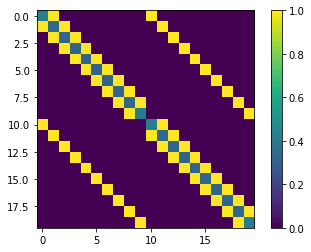

In [73]:
rows = [None] * M

for i in range(M):
    if i == 0:
        rows[i] = H + self_energy_left
    elif i == 1:
        rows[i] = V
    else:
        rows[i] = Null
    
for i in range(M):
    for j in range(1,M):
        print(i,j, 'Before:', rows[i].shape)
        if i == j:
            if j == M - 1:
                rows[i] = np.stack((rows[i], H + self_energy_right), axis=1).reshape((j + 1)*N, N)
            else:
                rows[i] = np.stack((rows[i], H), axis=1).reshape((j + 1)*N, N)
        if i == j - 1 or i == j + 1:
            rows[i] = np.stack((rows[i], V), axis=1).reshape((j + 1)*N, N)
        print('After:', rows[i].shape)

total_H = np.stack((rows[0], rows[1])).reshape(N*M ,N*M)
plt.imshow(np.absolute(total_H))
plt.colorbar()
psi = np.linalg.solve(total_H, np.ones(2 * N))

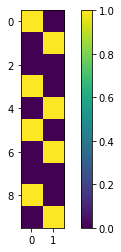

In [42]:
psi_squ = np.absolute(psi.reshape((N,M)))**2
plt.imshow(psi_squ)
plt.colorbar()